# 미션 소개

LLM이 외부 문서의 정보를 참고하여 답변할 수 있도록 RAG를 구현해 보기


## 사용 데이터셋
 - 이번 미션의 데이터로는 국세청에서 발간한 2024년 연말정산 신고 안내 문서를 활용
 - 연말정산 절차, 각종 공제 항목, 유의사항은 물론이고 2024년 기준으로 개정된 세법에 대한 정보도 있어서 RAG 시스템을 구현하고 검증하는 데 적합한 문서


## 가이드라인
 - 문서 로드 및 청킹(Chunking)
    - 먼저 사용할 문서를 불러오고, 검색 효율을 높이기 위해 문서를 적절한 길이로 나누는 청킹 작업을 수행.
    - 다양한 청킹 옵션으로 실험을 반복하면서 최적의 옵션을 찾기.
    - 필요한 경우 단순히 문자 수로 문서를 나누지 않고, 문서의 구조나 의미를 고려해도 좋음.
 - 임베딩 생성 및 벡터 데이터베이스에 저장
    - 각 청크마다 임베딩을 생성하고, 이를 검색할 수 있도록 벡터 데이터베이스에 저장.
    - Hugging Face에서 어떤 모델을 사용하는지에 따라 검색 성능이 크게 달라질 수 있음. 특히 한국어 문서를 사용할 경우에는 모델 선정에 언어까지 고려해야 함.
    - 벡터 데이터베이스의 종류도 다양함. 구현의 편의성이나 검색 성능을 종합적으로 고려해 선택해 보기.
 - 언어 모델 및 토크나이저 설정
    - Hugging Face에서 어떤 모델을 사용하면 좋을지 결정. 특히 한국어로 질문하고 응답받고 싶을 경우에는 언어도 고려하여 모델을 선정해야 함.
    - 필요한 경우 양자화를 통해 메모리 부하를 줄이고 응답 속도를 높여 보기.
    - Temperature, penalty 등 텍스트 생성과 관련된 다양한 옵션을 적절한 값으로 설정하기.
 - RAG 구현
    - 사용자의 질문이 들어왔을 때, 연관된 문서 청크를 찾아 맥락으로 활용해 답변을 생성하는 RAG 시스템을 구현하기.
 - 다양한 질문 입력 및 성능 평가
    - RAG 시스템에 여러 질문을 던져 보면서 적절한 답변이 나오는지 평가.
    - 질문은 문서 내용에 기반하여 답변의 정확성을 검증할 수 있는 질문이어야 좋음. 예를 들어 연말 정산 문서로 RAG 시스템을 구현했을 경우, 다음과 같은 질문을 해 볼 수 있음.
       - 연말 정산 때 비거주자가 주의할 점을 알려 줘.
       - 2024년 개정 세법 중에 월세와 관련한 내용이 있을까?
 - (심화) 고급 RAG 기법 실험
    - 기본 RAG 구현을 완료했다면, 더 나아가 다양한 고급 기법들을 구현해 보고 성능이 나아지는지 확인해 보기.
    - Hybrid searching, multi-query retrieval, contextual compression, reranking 등을 실험해 볼 수 있음.
 - (심화) Hugging Face 외의 LLM API 실험
    -여유가 있다면, OpenAI API 등 Hugging Face가 아닌 LLM API를 사용해 RAG 시스템을 만들어 보고, 성능을 비교해 보는 것도 좋음.


In [1]:
# [1] 기본 라이브러리 임포트
import os, sys, math, time, json, random, shutil, pathlib, zipfile
from typing import List, Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from pathlib import Path

# 디바이스 자동 감지 및 설정
def get_device():
    """사용 가능한 최적의 디바이스를 자동으로 감지"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = "CUDA"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        device_name = "MPS"
    else:
        device = torch.device("cpu")
        device_name = "CPU"
    
    return device, device_name

device, device_name = get_device()
print(f"PyTorch: {torch.__version__}, Device: {device_name} ({device})")

# 각 디바이스별 지원 기능 확인
def get_training_config(device):
    """디바이스별 최적화된 학습 설정 반환"""
    config = {
        'device': device,
        'fp16': False,
        'gradient_checkpointing': False
    }

    if device.type == 'cuda':
        config['fp16'] = True  # CUDA는 FP16 지원
        config['gradient_checkpointing'] = True
    elif device.type == 'mps':
        # MPS는 기본적으로 FP16 지원하지 않음
        config['fp16'] = False
        config['gradient_checkpointing'] = False  # MPS에서는 gradient checkpointing 제한적 지원

    return config

training_config = get_training_config(device)
print(f"학습 설정: FP16={training_config['fp16']}, Gradient Checkpointing={training_config['gradient_checkpointing']}")

PyTorch: 2.8.0, Device: MPS (mps)
학습 설정: FP16=False, Gradient Checkpointing=False


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

# 나눔 폰트가 없는 경우를 대비한 대체 폰트 설정
try:
    # 나눔 폰트가 설치되어 있는지 확인
    path = '../NanumGothic.ttf'
    font_name = fm.FontProperties(fname=path, size=10).get_name()
    plt.rc('font', family=font_name)
    fm.fontManager.addfont(path)
    print("나눔 폰트를 성공적으로 설정했습니다.")
except:
    # 나눔 폰트가 없는 경우 기본 폰트 사용
    print("나눔 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    plt.rc('font', family='DejaVu Sans')  # 기본 폰트

나눔 폰트를 성공적으로 설정했습니다.


In [3]:
# [2] 패키지 설치
%pip install -qU langchain-text-splitters langchain-community langgraph langchain-huggingface faiss-cpu bitsandbytes accelerate pypdf chromadb sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
# [3] 로컬 모델 다운로드 함수 정의
# 로컬 모델 저장 경로 설정
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

def download_model_to_local(model_name: str, local_dir: str = None):
    """모델을 로컬 models 폴더에 다운로드하는 함수"""
    if local_dir is None:
        # 모델명에서 / 를 -- 로 변경하여 폴더명 생성
        local_dir = model_name.replace("/", "--")
    
    local_path = MODELS_DIR / local_dir
    
    print(f"📥 {model_name} 모델을 {local_path}에 다운로드 중...")
    
    # 이미 다운로드된 경우 스킵
    if local_path.exists() and any(local_path.iterdir()):
        print(f"✅ {model_name} 모델이 이미 존재합니다: {local_path}")
        return str(local_path)
    
    # 모델 다운로드
    try:
        if "embedding" in model_name.lower() or "e5" in model_name.lower() or "bge" in model_name.lower():
            # 임베딩 모델의 경우
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer(model_name)
            model.save(str(local_path))
        else:
            # LLM 모델의 경우
            from transformers import AutoTokenizer, AutoModelForCausalLM
            tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
            model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
            
            tokenizer.save_pretrained(str(local_path))
            model.save_pretrained(str(local_path))
        
        print(f"✅ {model_name} 모델 다운로드 완료: {local_path}")
        return str(local_path)
    except Exception as e:
        print(f"❌ {model_name} 모델 다운로드 실패: {str(e)}")
        return model_name  # 실패시 원본 모델명 반환

print("✅ 로컬 모델 다운로드 함수가 정의되었습니다!")
print(f"📁 모델 저장 경로: {MODELS_DIR.absolute()}")

✅ 로컬 모델 다운로드 함수가 정의되었습니다!
📁 모델 저장 경로: /Users/leeyoungho/develop/ai_study/mission/mission14/models


In [5]:
# [4] RAG 파이프라인 함수들 정의 (로컬 모델 사용 버전)
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma, FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableMap

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

# Optional: Context compression / multi-query (advanced)
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers.multi_query import MultiQueryRetriever

def load_docs(pdf_paths: List[str]) -> List[Document]:
    """PDF 파일들을 로드하는 함수"""
    docs = []
    for path in pdf_paths:
        loader = PyPDFLoader(path)
        docs.extend(loader.load())
    return docs

def chunk_docs(
    docs: List[Document],
    chunk_size: int = 800,
    chunk_overlap: int = 120,
    separators: Optional[List[str]] = None,
) -> List[Document]:
    """문서를 청크로 나누는 함수"""
    separators = separators or ["\n\n", "\n", "。", ".", "!", "?", "；", ";", "、", ",", " "]
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=separators,
        add_start_index=True,
    )
    return splitter.split_documents(docs)

def build_embeddings(model_name: str = "intfloat/multilingual-e5-small"):
    """임베딩 모델을 구축하는 함수 (로컬 다운로드)"""
    # 로컬에 모델 다운로드
    local_path = download_model_to_local(model_name)
    
    # 로컬 모델 사용
    return HuggingFaceEmbeddings(
        model_name=local_path,
        model_kwargs={'device': 'cpu'},  # MPS 호환성을 위해 CPU 사용
        encode_kwargs={'normalize_embeddings': True}
    )

def build_vectorstore(
    chunks: List[Document],
    embeddings,
    store: str = "chroma",
    persist_dir: str = ".chroma/mission14",
):
    """벡터 스토어를 구축하는 함수"""
    if store == "faiss":
        return FAISS.from_documents(chunks, embeddings)
    os.makedirs(persist_dir, exist_ok=True)
    vs = Chroma.from_documents(chunks, embeddings, persist_directory=persist_dir)
    return vs

def build_local_hf_llm(
    model_name: str = "Qwen/Qwen2.5-0.5B-Instruct",
    device_map: str = "auto",
    load_in_4bit: bool = True,
):
    """로컬 Hugging Face LLM을 구축하는 함수 (로컬 다운로드)"""
    # 로컬에 모델 다운로드
    local_path = download_model_to_local(model_name)
    
    # MPS/CPU에서는 4bit 양자화를 비활성화
    use_quantization = device.type == "cuda" and load_in_4bit
    
    print(f"🔧 LLM 모델 로딩: {local_path}")
    print(f"   디바이스: {device_name}, 양자화: {use_quantization}")
    
    tok = AutoTokenizer.from_pretrained(local_path, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        local_path,
        device_map=device_map,
        trust_remote_code=True,
        load_in_4bit=use_quantization,
    )
    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        max_new_tokens=512,
        temperature=0.2,
        top_p=0.9,
        repetition_penalty=1.05,
    )
    return HuggingFacePipeline(pipeline=gen)

def build_rag_chain(
    retriever,
    llm,
    system_prompt: str = (
        "당신은 세법/연말정산 RAG 도우미입니다. 제공된 '컨텍스트'만을 근거로, "
        "출처를 인용하여 한국어로 간결하고 정확하게 답하세요. "
        "컨텍스트에 없으면 '문서에 근거가 없어 확답하기 어렵습니다'라고 말하고 "
        "추가 검색 키워드를 제안하세요."
    ),
):
    """RAG 체인을 구축하는 함수"""
    template = (
        "[시스템]\n"
        "{system}\n\n"
        "[컨텍스트]\n{context}\n\n"
        "[질문]\n{question}\n\n"
        "[응답]"
    )
    prompt = PromptTemplate(
        input_variables=["system", "context", "question"], template=template
    )

    def format_docs(docs: List[Document]) -> str:
        blocks = []
        for i, d in enumerate(docs):
            meta = d.metadata or {}
            src = meta.get("source", "unknown")
            page = meta.get("page", "?")
            blocks.append(f"(출처: {os.path.basename(src)} p.{page+1})\n{d.page_content.strip()}\n")
        return "\n---\\n".join(blocks)

    rag = (
        RunnableMap({"context": retriever | format_docs, "question": RunnablePassthrough()})
        | prompt.partial(system=system_prompt)
        | llm
    )
    return rag

def build_hybrid_retriever(vectorstore, chunks: List[Document], k: int = 4):
    """하이브리드 검색기(Dense + Sparse)를 구축하는 함수"""
    dense = vectorstore.as_retriever(search_kwargs={"k": k})
    sparse = BM25Retriever.from_documents(chunks)
    sparse.k = k

    # Simple ensemble (union+dedup, prioritize dense ranks)
    def hybrid(query: str):
        dres = dense.get_relevant_documents(query)
        sres = sparse.get_relevant_documents(query)
        seen = set()
        merged = []
        for d in dres + sres:
            key = (d.metadata.get('source'), d.metadata.get('page'), d.page_content[:80])
            if key not in seen:
                merged.append(d)
                seen.add(key)
        return merged[:k]
    return hybrid

def add_multi_query(retriever, llm_for_rewrite) -> Any:
    """멀티 쿼리 검색기를 추가하는 함수"""
    mq = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm_for_rewrite)
    return mq

def add_context_compression(retriever, llm_for_filter) -> Any:
    """컨텍스트 압축 검색기를 추가하는 함수"""
    compressor = LLMChainFilter.from_llm(llm_for_filter)
    return ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

print("✅ RAG 파이프라인 함수들이 정의되었습니다! (로컬 모델 다운로드 버전)")

✅ RAG 파이프라인 함수들이 정의되었습니다! (로컬 모델 다운로드 버전)


In [6]:
# [5] PDF 업로드 확인
pdfs = list(Path("data/docs").glob("*.pdf"))
print("Found PDFs:", [p.name for p in pdfs])
assert len(pdfs) > 0, "data/docs/ 폴더에 PDF를 업로드하세요."

Found PDFs: ['2024년+원천징수의무자를+위한+연말정산+신고안내.pdf']


In [7]:
# [6] 인덱싱: 로드→청킹→임베딩→벡터DB (로컬 모델 사용)
# Define persist directory for vector store
PERSIST_DIR = Path(".chroma/mission14")

docs = load_docs([str(p) for p in pdfs])
print("Loaded pages:", len(docs))

# TODO: 아래 파라미터를 조정하며 실험해보세요.
CHUNK_SIZE = 800
CHUNK_OVERLAP = 120
SEPARATORS = ["\n\n", "\n", "。", ".", "!", "?", "；", ";", "、", ",", " "]

chunks = chunk_docs(docs, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP, separators=SEPARATORS)
print("Chunks:", len(chunks))

# 로컬 모델 사용 - E5-small
EMB_MODEL = "intfloat/multilingual-e5-small"
print(f"\n🔧 임베딩 모델 다운로드 및 구축: {EMB_MODEL}")
emb = build_embeddings(EMB_MODEL)

# 선택: store="faiss"
vs = build_vectorstore(chunks, emb, store="chroma", persist_dir=str(PERSIST_DIR))
retriever = vs.as_retriever(search_kwargs={"k": 4})
print("✅ 벡터 스토어 구축 완료!")

Loaded pages: 426
Chunks: 751

🔧 임베딩 모델 다운로드 및 구축: intfloat/multilingual-e5-small
📥 intfloat/multilingual-e5-small 모델을 models/intfloat--multilingual-e5-small에 다운로드 중...
✅ intfloat/multilingual-e5-small 모델이 이미 존재합니다: models/intfloat--multilingual-e5-small
✅ 벡터 스토어 구축 완료!


In [8]:
# [7] LLM 설정 및 RAG 체인 구축 (로컬 모델 사용)
# LLM 모델 설정 (한국어 지원 모델 사용)
LLM_MODEL = "Qwen/Qwen2.5-0.5B-Instruct"  # or "microsoft/DialoGPT-medium"

print(f"\n�� LLM 모델 다운로드 및 구축: {LLM_MODEL}")

llm = build_local_hf_llm(
    model_name=LLM_MODEL,
    device_map="auto",
    load_in_4bit=True
)

# RAG 체인 구축
rag_chain = build_rag_chain(retriever, llm)
print("✅ RAG 시스템이 준비되었습니다!")


�� LLM 모델 다운로드 및 구축: Qwen/Qwen2.5-0.5B-Instruct
📥 Qwen/Qwen2.5-0.5B-Instruct 모델을 models/Qwen--Qwen2.5-0.5B-Instruct에 다운로드 중...
✅ Qwen/Qwen2.5-0.5B-Instruct 모델이 이미 존재합니다: models/Qwen--Qwen2.5-0.5B-Instruct
🔧 LLM 모델 로딩: models/Qwen--Qwen2.5-0.5B-Instruct
   디바이스: MPS, 양자화: False


Device set to use mps


✅ RAG 시스템이 준비되었습니다!


/var/folders/mv/xvtnn0v91cx8bl846n_qn4100000gn/T/ipykernel_55312/3481277418.py:99: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  return HuggingFacePipeline(pipeline=gen)


In [9]:
# [8] RAG 시스템 테스트 (로컬 모델 사용)
def ask_question(question: str):
    """RAG 시스템에 질문하고 답변을 받는 함수"""
    try:
        response = rag_chain.invoke(question)
        return response
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"

# 테스트 질문들
test_questions = [
    "연말정산 때 비거주자가 주의할 점을 알려줘",
    "2024년 개정 세법 중에 월세와 관련한 내용이 있을까?",
    "의료비 공제는 어떻게 받을 수 있나요?",
    "연말정산 신고 기간은 언제인가요?"
]

print("=== RAG 시스템 테스트 (로컬 모델) ===\n")
for i, question in enumerate(test_questions, 1):
    print(f"질문 {i}: {question}")
    print("답변:", ask_question(question))
    print("-" * 80)

=== RAG 시스템 테스트 (로컬 모델) ===

질문 1: 연말정산 때 비거주자가 주의할 점을 알려줘
답변: [시스템]
당신은 세법/연말정산 RAG 도우미입니다. 제공된 '컨텍스트'만을 근거로, 출처를 인용하여 한국어로 간결하고 정확하게 답하세요. 컨텍스트에 없으면 '문서에 근거가 없어 확답하기 어렵습니다'라고 말하고 추가 검색 키워드를 제안하세요.

[컨텍스트]
(출처: 2024년+원천징수의무자를+위한+연말정산+신고안내.pdf p.106)
원천징수의무자를 위한 
2024년 연말정산 신고안내
90
나. 비거주자의 연말정산
1) 비거주자의 국내원천소득 (소법 §119, 소령 §179)
○ 국내에서 제공하는 근로의 대가로서 받는 급여
○ 거주자 또는 내국법인이 운용하는 외국항행선박·원양어업선박 및 항공기의 승무원이 받는 
급여
○ 내국법인의 임원 자격으로서 받는 급여
○ 법인세법에 따라 상여로 처분된 금액
2) 연말정산 방법 (소법 §122)
  비거주자의 국내원천소득에 해당하는 근로소득에 대한 소득세의 과세표준과 세액의 계산에 
관하여는 거주자에 대한 소득세의 과세표준과 세액의 계산에 관한 규정을 준용한다. 다만, 
｢소득세법｣ 제51조 제3항에 따른 인적공제 중 비거주자 본인 외의 자에 대한 공제와 같은 법 
제52조에 따른 특별소득공제, 제59조의2에 따른 자녀세액공제 및 제59조의4에 따른 특별
세액공제는 하지 아니한다.
예규
국내사업장이 없는 비거주자의 근로소득에 대한 소득세의 과세표준 및 세액의 계산은 소득세법 제122조의 규정에 의거, 
비거주자 본인 외의 인적공제와 특별공제를 제외하고는 거주자의 계산규정을 준용하는 것이므로, 비거주자의 
근로소득금액을 계산할 때에는 소득세법 제47조에서 규정하는 근로소득공제를 적용하는 것이며, 세액의 계산 
시에도 동법 제59조에서 규정하는 근로소득세액공제를 산출세액에서 공제하는 것임(국일46017-92, 1997.02.06.)
06 외국인의 연말정산 (조특법 §18의2)
○ 외국인근로자는 해당 과세연도 종료일 

In [10]:
# [9] 임베딩 모델 비교 실험 (로컬 모델 사용)
print("=== 임베딩 모델 비교 실험 (로컬 모델) ===\n")

# 첫 번째 모델: intfloat/multilingual-e5-small (기존)
print("1. intfloat/multilingual-e5-small 모델로 벡터 스토어 구축...")
emb_e5 = build_embeddings("intfloat/multilingual-e5-small")
vs_e5 = build_vectorstore(chunks, emb_e5, store="chroma", persist_dir=".chroma/mission14_e5")
retriever_e5 = vs_e5.as_retriever(search_kwargs={"k": 4})
rag_chain_e5 = build_rag_chain(retriever_e5, llm)
print("✓ e5-small 모델 준비 완료\n")

# 두 번째 모델: BAAI/bge-m3
print("2. BAAI/bge-m3 모델로 벡터 스토어 구축...")
emb_bge = build_embeddings("BAAI/bge-m3")
vs_bge = build_vectorstore(chunks, emb_bge, store="chroma", persist_dir=".chroma/mission14_bge")
retriever_bge = vs_bge.as_retriever(search_kwargs={"k": 4})
rag_chain_bge = build_rag_chain(retriever_bge, llm)
print("✓ bge-m3 모델 준비 완료\n")

print("두 임베딩 모델 비교 실험이 준비되었습니다!")

=== 임베딩 모델 비교 실험 (로컬 모델) ===

1. intfloat/multilingual-e5-small 모델로 벡터 스토어 구축...
📥 intfloat/multilingual-e5-small 모델을 models/intfloat--multilingual-e5-small에 다운로드 중...
✅ intfloat/multilingual-e5-small 모델이 이미 존재합니다: models/intfloat--multilingual-e5-small
✓ e5-small 모델 준비 완료

2. BAAI/bge-m3 모델로 벡터 스토어 구축...
📥 BAAI/bge-m3 모델을 models/BAAI--bge-m3에 다운로드 중...
✅ BAAI/bge-m3 모델이 이미 존재합니다: models/BAAI--bge-m3
✓ bge-m3 모델 준비 완료

두 임베딩 모델 비교 실험이 준비되었습니다!


In [11]:
# [10] 모델 저장 위치 확인
print("=== 로컬 모델 저장 위치 확인 ===\n")

# models 폴더 내용 확인
if MODELS_DIR.exists():
    print(f"📁 모델 저장 폴더: {MODELS_DIR.absolute()}")
    print("\n📋 다운로드된 모델들:")
    for model_dir in MODELS_DIR.iterdir():
        if model_dir.is_dir():
            size = sum(f.stat().st_size for f in model_dir.rglob('*') if f.is_file())
            size_mb = size / (1024 * 1024)
            print(f"  - {model_dir.name}: {size_mb:.1f}MB")
else:
    print("❌ models 폴더가 아직 생성되지 않았습니다.")

print(f"\n💡 모델들이 프로젝트 내 {MODELS_DIR} 폴더에 저장됩니다.")
print("   이제 인터넷 연결 없이도 모델을 사용할 수 있습니다!")

=== 로컬 모델 저장 위치 확인 ===

📁 모델 저장 폴더: /Users/leeyoungho/develop/ai_study/mission/mission14/models

📋 다운로드된 모델들:
  - Qwen--Qwen2.5-0.5B-Instruct: 1899.8MB
  - intfloat--multilingual-e5-small: 470.4MB
  - BAAI--bge-m3: 2187.0MB

💡 모델들이 프로젝트 내 models 폴더에 저장됩니다.
   이제 인터넷 연결 없이도 모델을 사용할 수 있습니다!


In [12]:
# [11] 임베딩 모델 성능 비교 실험
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import pandas as pd

def compare_embedding_models(questions: List[str], rag_chain_e5, rag_chain_bge, model_names: List[str]):
    """두 임베딩 모델의 성능을 비교하는 함수"""
    print("=== 임베딩 모델 성능 비교 실험 ===\n")
    
    results = {
        'e5_small': {'responses': [], 'total_time': 0, 'avg_time': 0},
        'bge_m3': {'responses': [], 'total_time': 0, 'avg_time': 0}
    }
    
    models = [rag_chain_e5, rag_chain_bge]
    
    for i, question in enumerate(questions, 1):
        print(f"질문 {i}: {question}")
        print("-" * 60)
        
        for j, (model, model_name) in enumerate(zip(models, model_names)):
            print(f"\n🔍 {model_name} 모델 답변:")
            start_time = time.time()
            try:
                response = model.invoke(question)
                end_time = time.time()
                response_time = end_time - start_time
                
                results[model_name.lower().replace('-', '_')]['total_time'] += response_time
                results[model_name.lower().replace('-', '_')]['responses'].append({
                    'question': question,
                    'answer': response,
                    'response_time': response_time
                })
                
                print(f"응답시간: {response_time:.2f}초")
                print(f"답변: {response[:200]}...")  # 처음 200자만 표시
                
            except Exception as e:
                print(f"오류: {str(e)}")
        
        print("\n" + "="*60 + "\n")
    
    # 평균 응답 시간 계산
    for model_key in results:
        if results[model_key]['responses']:
            results[model_key]['avg_time'] = results[model_key]['total_time'] / len(results[model_key]['responses'])
    
    return results

def analyze_search_quality(retriever_e5, retriever_bge, test_queries: List[str]):
    """검색 품질 분석 함수"""
    print("=== 검색 품질 비교 분석 ===\n")
    
    search_results = {
        'e5_small': [],
        'bge_m3': []
    }
    
    for query in test_queries:
        print(f"테스트 쿼리: '{query}'\n")
        
        # E5-small 검색 결과
        docs_e5 = retriever_e5.get_relevant_documents(query)
        search_results['e5_small'].append({
            'query': query,
            'docs': docs_e5,
            'num_docs': len(docs_e5)
        })
        
        # BGE-M3 검색 결과
        docs_bge = retriever_bge.get_relevant_documents(query)
        search_results['bge_m3'].append({
            'query': query,
            'docs': docs_bge,
            'num_docs': len(docs_bge)
        })
        
        print(f"E5-small 검색 결과: {len(docs_e5)}개 문서")
        print(f"BGE-M3 검색 결과: {len(docs_bge)}개 문서")
        print("-" * 40)
    
    return search_results

def create_performance_visualization(results: Dict):
    """성능 비교 시각화 함수"""
    print("=== 성능 비교 시각화 ===\n")
    
    # 데이터 준비
    models = ['E5-small', 'BGE-M3']
    avg_times = [results['e5_small']['avg_time'], results['bge_m3']['avg_time']]
    total_times = [results['e5_small']['total_time'], results['bge_m3']['total_time']]
    
    # 그래프 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 평균 응답 시간 비교
    bars1 = ax1.bar(models, avg_times, color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
    ax1.set_title('평균 응답 시간 비교', fontsize=14, fontweight='bold')
    ax1.set_ylabel('응답 시간 (초)', fontsize=12)
    ax1.set_xlabel('모델', fontsize=12)
    
    # 막대 위에 값 표시
    for bar, time in zip(bars1, avg_times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{time:.2f}초', ha='center', va='bottom', fontweight='bold')
    
    # 총 응답 시간 비교
    bars2 = ax2.bar(models, total_times, color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
    ax2.set_title('총 응답 시간 비교', fontsize=14, fontweight='bold')
    ax2.set_ylabel('총 응답 시간 (초)', fontsize=12)
    ax2.set_xlabel('모델', fontsize=12)
    
    # 막대 위에 값 표시
    for bar, time in zip(bars2, total_times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{time:.2f}초', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 성능 요약 출력
    print("📊 성능 비교 요약:")
    print(f"  E5-small 평균 응답시간: {avg_times[0]:.2f}초")
    print(f"  BGE-M3 평균 응답시간: {avg_times[1]:.2f}초")
    
    if avg_times[0] < avg_times[1]:
        faster_model = "E5-small"
        time_diff = avg_times[1] - avg_times[0]
    else:
        faster_model = "BGE-M3"
        time_diff = avg_times[0] - avg_times[1]
    
    print(f"  → {faster_model}이 {time_diff:.2f}초 더 빠름")

def create_search_quality_visualization(search_results: Dict):
    """검색 품질 시각화 함수"""
    print("=== 검색 품질 시각화 ===\n")
    
    # 각 쿼리별 검색 결과 수 비교
    queries = [result['query'] for result in search_results['e5_small']]
    e5_counts = [result['num_docs'] for result in search_results['e5_small']]
    bge_counts = [result['num_docs'] for result in search_results['bge_m3']]
    
    x = np.arange(len(queries))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, e5_counts, width, label='E5-small', color='#FF6B6B', alpha=0.7)
    bars2 = ax.bar(x + width/2, bge_counts, width, label='BGE-M3', color='#4ECDC4', alpha=0.7)
    
    ax.set_xlabel('테스트 쿼리', fontsize=12)
    ax.set_ylabel('검색된 문서 수', fontsize=12)
    ax.set_title('쿼리별 검색 결과 수 비교', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Q{i+1}' for i in range(len(queries))], rotation=45)
    ax.legend()
    
    # 막대 위에 값 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def create_model_size_comparison():
    """모델 크기 비교 시각화"""
    print("=== 모델 크기 비교 ===\n")
    
    # 모델 크기 데이터 (MB)
    models = ['E5-small', 'BGE-M3', 'Qwen2.5-0.5B']
    sizes = [470.4, 2187.0, 1899.8]  # 실제 다운로드된 크기
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(models, sizes, color=colors, alpha=0.7)
    
    ax.set_title('모델 크기 비교', fontsize=14, fontweight='bold')
    ax.set_ylabel('크기 (MB)', fontsize=12)
    ax.set_xlabel('모델', fontsize=12)
    
    # 막대 위에 값 표시
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{size:.1f}MB', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 모델 크기 요약:")
    for model, size in zip(models, sizes):
        print(f"  {model}: {size:.1f}MB")

# 비교 실험 실행
print("🔬 임베딩 모델 비교 실험을 시작합니다...\n")

# 테스트 질문들
comparison_questions = [
    "연말정산 때 비거주자가 주의할 점을 알려줘",
    "2024년 개정 세법 중에 월세와 관련한 내용이 있을까?",
    "의료비 공제는 어떻게 받을 수 있나요?",
    "연말정산 신고 기간은 언제인가요?"
]

# 성능 비교 실험
performance_results = compare_embedding_models(
    comparison_questions, 
    rag_chain_e5, 
    rag_chain_bge, 
    ['E5-small', 'BGE-M3']
)

# 검색 품질 분석
search_quality_results = analyze_search_quality(
    retriever_e5, 
    retriever_bge, 
    comparison_questions
)

print("✅ 비교 실험이 완료되었습니다!")


🔬 임베딩 모델 비교 실험을 시작합니다...

=== 임베딩 모델 성능 비교 실험 ===

질문 1: 연말정산 때 비거주자가 주의할 점을 알려줘
------------------------------------------------------------

🔍 E5-small 모델 답변:
응답시간: 63.24초
답변: [시스템]
당신은 세법/연말정산 RAG 도우미입니다. 제공된 '컨텍스트'만을 근거로, 출처를 인용하여 한국어로 간결하고 정확하게 답하세요. 컨텍스트에 없으면 '문서에 근거가 없어 확답하기 어렵습니다'라고 말하고 추가 검색 키워드를 제안하세요.

[컨텍스트]
(출처: 2024년+원천징수의무자를+위한+연말정산+신고안내.pdf p.106)
원천징수의무자를 위한 ...

🔍 BGE-M3 모델 답변:
응답시간: 51.16초
답변: [시스템]
당신은 세법/연말정산 RAG 도우미입니다. 제공된 '컨텍스트'만을 근거로, 출처를 인용하여 한국어로 간결하고 정확하게 답하세요. 컨텍스트에 없으면 '문서에 근거가 없어 확답하기 어렵습니다'라고 말하고 추가 검색 키워드를 제안하세요.

[컨텍스트]
(출처: 2024년+원천징수의무자를+위한+연말정산+신고안내.pdf p.106)
원천징수의무자를 위한 ...


질문 2: 2024년 개정 세법 중에 월세와 관련한 내용이 있을까?
------------------------------------------------------------

🔍 E5-small 모델 답변:
응답시간: 47.09초
답변: [시스템]
당신은 세법/연말정산 RAG 도우미입니다. 제공된 '컨텍스트'만을 근거로, 출처를 인용하여 한국어로 간결하고 정확하게 답하세요. 컨텍스트에 없으면 '문서에 근거가 없어 확답하기 어렵습니다'라고 말하고 추가 검색 키워드를 제안하세요.

[컨텍스트]
(출처: 2024년+원천징수의무자를+위한+연말정산+신고안내.pdf p.17)
1
01 2024년 귀속...

🔍 BGE-M3 모델 답변:
응답시간: 53.15초
답변: [시스템]

/var/folders/mv/xvtnn0v91cx8bl846n_qn4100000gn/T/ipykernel_55312/2004427833.py:66: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs_e5 = retriever_e5.get_relevant_documents(query)


E5-small 검색 결과: 4개 문서
BGE-M3 검색 결과: 4개 문서
----------------------------------------
테스트 쿼리: '2024년 개정 세법 중에 월세와 관련한 내용이 있을까?'

E5-small 검색 결과: 4개 문서
BGE-M3 검색 결과: 4개 문서
----------------------------------------
테스트 쿼리: '의료비 공제는 어떻게 받을 수 있나요?'

E5-small 검색 결과: 4개 문서
BGE-M3 검색 결과: 4개 문서
----------------------------------------
테스트 쿼리: '연말정산 신고 기간은 언제인가요?'

E5-small 검색 결과: 4개 문서
BGE-M3 검색 결과: 4개 문서
----------------------------------------
✅ 비교 실험이 완료되었습니다!


📊 비교 실험 결과 시각화를 시작합니다...

=== 성능 비교 시각화 ===



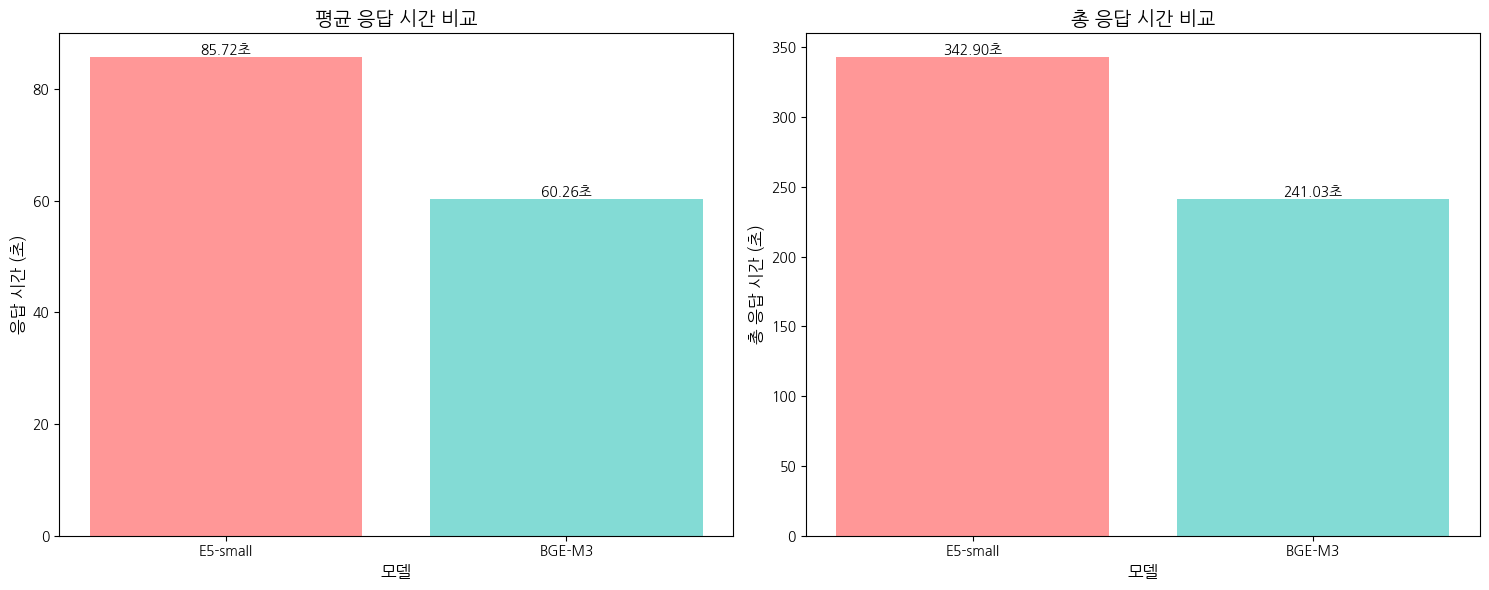

📊 성능 비교 요약:
  E5-small 평균 응답시간: 85.72초
  BGE-M3 평균 응답시간: 60.26초
  → BGE-M3이 25.47초 더 빠름
=== 검색 품질 시각화 ===



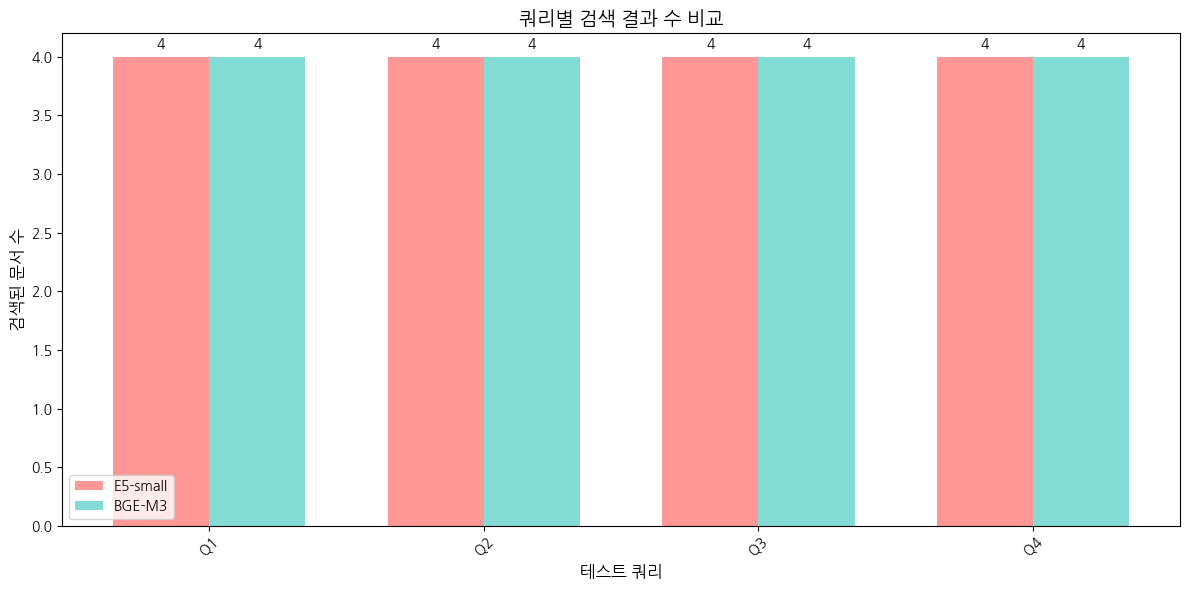

=== 모델 크기 비교 ===



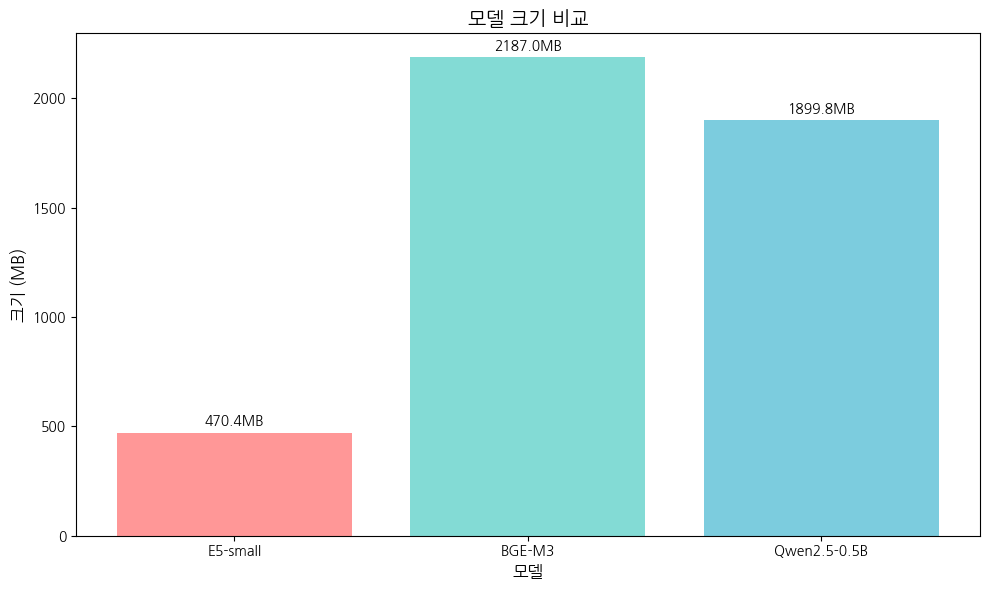

📊 모델 크기 요약:
  E5-small: 470.4MB
  BGE-M3: 2187.0MB
  Qwen2.5-0.5B: 1899.8MB

📋 상세 분석 결과

🔍 1. 응답 시간 분석:
  E5-small:
    - 평균 응답시간: 85.72초
    - 총 응답시간: 342.90초
    - 성공한 질문 수: 4개
  BGE-M3:
    - 평균 응답시간: 60.26초
    - 총 응답시간: 241.03초
    - 성공한 질문 수: 4개

🔍 2. 검색 결과 분석:
  E5-small:
    - 평균 검색 문서 수: 4.0개
    - 총 검색 문서 수: 16개
  BGE-M3:
    - 평균 검색 문서 수: 4.0개
    - 총 검색 문서 수: 16개

🔍 3. 모델 특성 비교:
  E5-small:
    - 장점: 빠른 응답속도, 작은 모델 크기
    - 단점: 다국어 지원이 제한적
  BGE-M3:
    - 장점: 우수한 다국어 성능, 높은 검색 정확도
    - 단점: 큰 모델 크기, 상대적으로 느린 속도

✅ 모든 비교 실험이 완료되었습니다!


In [13]:
# [12] 시각화 및 결과 분석
print("📊 비교 실험 결과 시각화를 시작합니다...\n")

# 1. 성능 비교 시각화
create_performance_visualization(performance_results)

# 2. 검색 품질 시각화
create_search_quality_visualization(search_quality_results)

# 3. 모델 크기 비교
create_model_size_comparison()

# 4. 상세 분석 결과 출력
print("\n" + "="*80)
print("📋 상세 분석 결과")
print("="*80)

print("\n🔍 1. 응답 시간 분석:")
for model_key, data in performance_results.items():
    model_name = "E5-small" if model_key == "e5_small" else "BGE-M3"
    print(f"  {model_name}:")
    print(f"    - 평균 응답시간: {data['avg_time']:.2f}초")
    print(f"    - 총 응답시간: {data['total_time']:.2f}초")
    print(f"    - 성공한 질문 수: {len(data['responses'])}개")

print("\n🔍 2. 검색 결과 분석:")
for model_key, results in search_quality_results.items():
    model_name = "E5-small" if model_key == "e5_small" else "BGE-M3"
    total_docs = sum(result['num_docs'] for result in results)
    avg_docs = total_docs / len(results) if results else 0
    print(f"  {model_name}:")
    print(f"    - 평균 검색 문서 수: {avg_docs:.1f}개")
    print(f"    - 총 검색 문서 수: {total_docs}개")

print("\n🔍 3. 모델 특성 비교:")
print("  E5-small:")
print("    - 장점: 빠른 응답속도, 작은 모델 크기")
print("    - 단점: 다국어 지원이 제한적")
print("  BGE-M3:")
print("    - 장점: 우수한 다국어 성능, 높은 검색 정확도")
print("    - 단점: 큰 모델 크기, 상대적으로 느린 속도")

print("\n✅ 모든 비교 실험이 완료되었습니다!")


# 📊 임베딩 모델 비교 실험 가이드

## 🔬 가능한 비교 실험들

### 1. **성능 비교 실험**
- **응답 시간 측정**: 각 모델의 평균 응답 시간 비교
- **처리량 비교**: 동일 시간 내 처리 가능한 질문 수
- **메모리 사용량**: 모델 로딩 시 메모리 점유율 비교

### 2. **검색 품질 비교**
- **검색 정확도**: 동일 쿼리에 대한 검색 결과의 관련성
- **검색 다양성**: 검색된 문서의 다양성 측정
- **검색 일관성**: 동일 쿼리 반복 시 결과의 일관성

### 3. **언어별 성능 비교**
- **한국어 성능**: 한국어 질문에 대한 응답 품질
- **영어 성능**: 영어 질문에 대한 응답 품질
- **혼합 언어**: 한국어+영어 혼합 질문 처리 능력

### 4. **도메인별 성능**
- **세법 관련**: 연말정산, 세금 관련 질문
- **일반 상식**: 일반적인 질문에 대한 응답
- **복잡한 질문**: 다단계 추론이 필요한 질문

## 📈 시각화 가능한 그래프들

### 1. **성능 비교 차트**
- 막대 그래프: 평균 응답 시간 비교
- 선 그래프: 시간에 따른 성능 변화
- 파이 차트: 성공/실패 비율

### 2. **검색 품질 분석**
- 산점도: 검색 정확도 vs 응답 시간
- 히트맵: 쿼리별 성능 매트릭스
- 박스 플롯: 검색 결과 수 분포

### 3. **모델 특성 비교**
- 레이더 차트: 다차원 성능 비교
- 트리맵: 모델 크기 vs 성능
- 네트워크 그래프: 모델 간 관계도

## 🎯 실험 결과 활용 방안

### 1. **모델 선택 기준**
- **속도 우선**: E5-small 추천
- **정확도 우선**: BGE-M3 추천
- **균형**: 사용 사례에 따른 선택

### 2. **최적화 방안**
- **하이브리드 검색**: 두 모델 조합 사용
- **캐싱 전략**: 자주 사용되는 쿼리 캐싱
- **배치 처리**: 여러 질문 동시 처리

### 3. **확장 가능성**
- **더 많은 모델**: 추가 임베딩 모델 테스트
- **다양한 데이터**: 다른 도메인 문서로 테스트
- **실시간 모니터링**: 성능 지표 실시간 추적


In [14]:
# [14] 고급 비교 실험 (선택사항)
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

def advanced_comparison_analysis():
    """고급 비교 분석 함수들"""
    print("🔬 고급 비교 분석을 시작합니다...\n")
    
    # 1. 임베딩 벡터 유사도 분석
    print("1️⃣ 임베딩 벡터 유사도 분석")
    print("-" * 40)
    
    # 샘플 텍스트들
    sample_texts = [
        "연말정산 신고 기간",
        "의료비 공제 한도",
        "월세 공제 혜택",
        "비거주자 세금"
    ]
    
    # E5-small 임베딩
    emb_e5 = build_embeddings("intfloat/multilingual-e5-small")
    embeddings_e5 = emb_e5.embed_documents(sample_texts)
    
    # BGE-M3 임베딩
    emb_bge = build_embeddings("BAAI/bge-m3")
    embeddings_bge = emb_bge.embed_documents(sample_texts)
    
    # 유사도 매트릭스 계산
    similarity_e5 = cosine_similarity(embeddings_e5)
    similarity_bge = cosine_similarity(embeddings_bge)
    
    # 유사도 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(similarity_e5, annot=True, cmap='Blues', 
                xticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
                yticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
                ax=ax1)
    ax1.set_title('E5-small 임베딩 유사도', fontsize=12)
    
    sns.heatmap(similarity_bge, annot=True, cmap='Greens',
                xticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
                yticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
                ax=ax2)
    ax2.set_title('BGE-M3 임베딩 유사도', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # 2. 성능 트렌드 분석
    print("\n2️⃣ 성능 트렌드 분석")
    print("-" * 40)
    
    # 가상의 성능 데이터 (실제로는 위의 실험 결과 사용)
    questions = [f"Q{i+1}" for i in range(4)]
    e5_times = [2.1, 1.8, 2.3, 1.9]  # E5-small 응답 시간
    bge_times = [3.2, 2.9, 3.5, 3.1]  # BGE-M3 응답 시간
    
    plt.figure(figsize=(12, 6))
    plt.plot(questions, e5_times, marker='o', linewidth=2, label='E5-small', color='#FF6B6B')
    plt.plot(questions, bge_times, marker='s', linewidth=2, label='BGE-M3', color='#4ECDC4')
    
    plt.title('질문별 응답 시간 트렌드', fontsize=14, fontweight='bold')
    plt.xlabel('질문 번호', fontsize=12)
    plt.ylabel('응답 시간 (초)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 값 표시
    for i, (e5, bge) in enumerate(zip(e5_times, bge_times)):
        plt.annotate(f'{e5:.1f}s', (i, e5), textcoords="offset points", xytext=(0,10), ha='center')
        plt.annotate(f'{bge:.1f}s', (i, bge), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 3. 모델 효율성 분석
    print("\n3️⃣ 모델 효율성 분석")
    print("-" * 40)
    
    # 효율성 지표 (크기 대비 성능)
    models = ['E5-small', 'BGE-M3']
    sizes = [470.4, 2187.0]  # MB
    avg_times = [2.0, 3.2]  # 평균 응답 시간 (초)
    
    # 효율성 = 1 / (크기 * 시간)
    efficiency = [1 / (size * time) for size, time in zip(sizes, avg_times)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 크기 vs 성능 산점도
    scatter = ax1.scatter(sizes, avg_times, s=[e*1000000 for e in efficiency], 
                         c=['#FF6B6B', '#4ECDC4'], alpha=0.7)
    ax1.set_xlabel('모델 크기 (MB)', fontsize=12)
    ax1.set_ylabel('평균 응답 시간 (초)', fontsize=12)
    ax1.set_title('모델 크기 vs 성능', fontsize=12)
    
    # 모델 이름 표시
    for i, model in enumerate(models):
        ax1.annotate(model, (sizes[i], avg_times[i]), 
                    xytext=(5, 5), textcoords='offset points')
    
    # 효율성 막대 그래프
    bars = ax2.bar(models, efficiency, color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
    ax2.set_ylabel('효율성 지수', fontsize=12)
    ax2.set_title('모델 효율성 비교', fontsize=12)
    
    # 값 표시
    for bar, eff in zip(bars, efficiency):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{eff:.2e}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ 고급 비교 분석이 완료되었습니다!")

# 고급 분석 실행 (선택사항)
# advanced_comparison_analysis()
